In [ ]:
!pip install sympy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#Library used in the script

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sympy import sinh, cosh, tanh, sin, cos, lambdify, symbols, pi, Sum


## Fluid mechanics inside a microchannel of rectangular geometry

Fluid mechanics inside a microfluidic rectangular channel with the coordinate system placed in the center of the channel (half width and half height). The center has coordenates (0, 0, 0). The $x$ axis is the direction of the flow inside the channel. The $y$ axis is change in width of the channel. The $z$ axis is the height of the channel. The $x$ and $y$ boundaries are defined as 
-width/2 < $y$ < width/2 and -height/2 < $z$ < height/2. 


In [2]:
""" 
  FUNCTIONS to compute the instantaneous velocity of the fluid inside the 
  rectangular channel, pressure drop across the channel, and 
  the wall shear stress 
"""

#Create all the symbols needed for the symbolic mathematics
#Notation for the symbols: 
#     y and z are the y axis and z axis
#     h and w are the height and the width of the channel 
#     eta and v are the viscosity of the cell cultyre media
#     n is the expansion order of the Fourier series

y, z, h, w, dpdx, eta, n = symbols('y, z, h, w, dpdx, eta, n')


""" 
  VELOCITY PROFILE
  The maximum velocity inside the channels is obtained at (y=0, z=0), the center
  of the channel (half height) and it is 0 at the channel walls. 
  All variables in SI units (velocity is given in m/s)
"""

#Split the terms of the velocity_x(y, z)
term_sum = ((-1)**n/(2*n+1)**3)*(1 - (cosh((2*n+1)*pi*y/h)/cosh((2*n+1)*pi*1/2*w/h)))*cos((2*n+1)*pi*z/h)
term_constant = (-4*(h**2)/eta*(pi**3))*dpdx

#Convert the SymPy expression to an equivalent NumPy function for numerical analysis
f = term_constant * Sum(term_sum, (n, 0, 10))
velocity_x = lambdify((y, z, h, w, dpdx, eta), f, 'numpy')


def pressure_drop(Q, h, w):
  """
    PRESSURE DROP along the channel's length inside the rectangular channels. 
    Input units must be uL/min (for Q), and micrometers (for both h and w) 
    Input: flow rate (Q), (height (h), width (w))
    Output unit is Pa/m (SI units)
    Output: pressure drop (dpdx) 
  """
  # Convert all input units to SI units
  h = h / (1*10**6) # SI unit (m)
  w = w / (1*10**6) # SI unit (m)
  eta = 0.00105 # SI unit (Pa.s)
  Q = Q * (1.67*10**(-11)) # SI unit (m3/s)

  x = Q / (1 - (0.630 * h / w))
  y = (12 * eta) / (w * h**3)

  #Return the pressure drop along the channel, SI units in Pa/m
  return x*y 
  

def wall_shear_stress(Q, h, w):
  """
    WALL SHEAR STRESS inside the rectangular channels.
    Input units must be uL/min (for Q), and micrometers (for both h and w) 
    Input: flow rate (Q), (height (h), width (w))
    Output unit is Dyn/cm2 (SI units)
    Output: wall shear stress (tau) 
  """

  # Convert all input units to SI units
  h = h / (1*10**6) # SI unit (m)
  w = w / (1*10**6) # SI unit (m)
  eta = 0.00105 # SI unit (Pa.s)
  Q = Q * (1.67*10**(-11)) # SI unit (m3/s)
  
  x = 6 * eta * Q
  y = w * h**2

  #Return the wall shear stress, units Dyn/cm2
  return x/y*10


def avg_velocity(Q, h, w):
  """
    AVERAGE VELOCITY inside the rectangular channels.
    Input units must be uL/min (for Q), and micrometers (for both h and w) 
    Input: flow rate (Q), (height (h), width (w))
    Output unit is m/s (SI units)
    Output: avg_velocity  
  """

  # Convert all input units to SI units
  h = h / (1*10**6) # SI unit (m)
  w = w / (1*10**6) # SI unit (m)
  Q = Q * (1.67*10**(-11)) # SI unit (m3/s)

  #return the average velocity, SI units in m/s
  return Q / (h * w)


def reynolds_number(Q, h, w):
  """
    REYNOLDS NUMBER inside the rectangular channels.
    Input units must be uL/min (for Q), and micrometers (for both h and w) 
    Input: flow rate (Q), (height (h), width (w))
    Output is dimensionless
    Output: reynolds_number

  """
  # Assuming the fluid to the cell culture media with 20% FBS,
  # the fluid viscosity and fluid density in SI units are
  fluid_viscosity = 0.00105 #Unit (Pa.s)
  fluid_density = 1023 #Unit (Kg/m3)

  ## Convert all input units to SI units
  h = h / (1*10**6) # SI unit (m)
  w = w / (1*10**6) # SI unit (m)
  Q = Q * (1.67*10**(-11)) # SI unit (m3/s) 

  #Compute cross-section area and wetter perimeter
  cross_section_area = 2 * h * w
  wetted_perimeter = w + h

  #Compute the hydraulic diameter
  hydraulic_diameter = cross_section_area / wetted_perimeter

  #Compute velocity 
  velocity = Q / (h * w)

  #Return Reynolds number 
  return (fluid_density * velocity * hydraulic_diameter) / fluid_viscosity



In [3]:
"""
  COMPUTE the wall shear stress, pressure drop along the channel, 
  and the average velocity for different channel's width and flow rates 
"""

#Input
range_width = np.arange(1000, 10500, 500) #Unit (micrometers)
range_flowRate = np.arange(100, 400, 100) #Unit (microliters/min)
height = 100 #Unit (micrometers)

#Store dpdx, shear stress, avg velocity for individual values of flow rate
p_change, ss_change, v_avg = [], [], [] 
#Store all values of dpdx, shear stress, and avg velocity
p_change_fr, ss_change_fr, v_avg_fr = [], [], [] 

#Compute the values
for value_fr in range_flowRate:
  for value_w in range_width:
    #Compute the pressure drop along the channel
    p = pressure_drop(value_fr, height, value_w) 
    #Compute the wall shear stress 
    wss = wall_shear_stress(value_fr, height, value_w) 
    #Compute the avg_velocity
    v = avg_velocity(value_fr, height, value_w)  

    #Store the values in the respective lists
    p_change.append(p / 1000) #Dpdx is in Unit of (Pa/mm)
    ss_change.append(wss) #Shear stress is in Unit of (Dyn/cm2)
    v_avg.append(v * 1000) #Velocity avg is in Unit of (mm/s)

  #Append the final list and reset intermediate list  
  p_change_fr.append(p_change)
  ss_change_fr.append(ss_change)
  v_avg_fr.append(v_avg)
  p_change, ss_change, v_avg = [], [], []


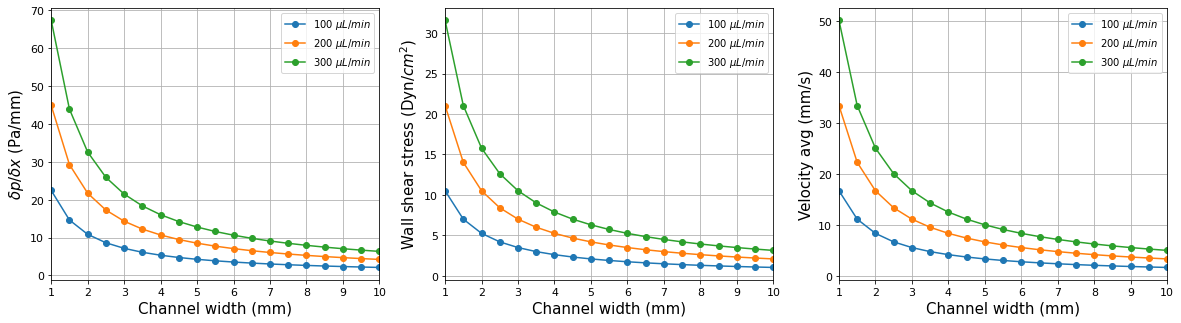

In [4]:
"""
  PLOTTING the wall shear stress, rate of change in pressure along the channel, 
  and the average velocity for different channel's width and flow rates 
"""

# Create figure with different axes
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#Labels for the data
label_w = np.arange(1, 10.5, 0.5) # Unit (mm)
label_fr = np.arange(100, 400, 100) #Unit (uL/min)
x_label = 'Channel width (mm)'
y_label = ['$\delta p/\delta x$ (Pa/mm)', 'Wall shear stress (Dyn/$cm^2$)', 'Velocity avg (mm/s)']
x_lim = [1, 10]

#Plot data
for i in range(len(p_change_fr)):
  axes[0].plot(label_w, p_change_fr[i], 'o-', label=f'{label_fr[i]} $\mu L/min$')
  axes[1].plot(label_w, ss_change_fr[i], 'o-', label=f'{label_fr[i]} $\mu L/min$')
  axes[2].plot(label_w, v_avg_fr[i], 'o-', label=f'{label_fr[i]} $\mu L/min$')

#Label plots
i_axes = 0
for axes_plot in axes.flat:
  axes_plot.set_xlabel(x_label, fontsize=15)
  axes_plot.set_ylabel(y_label[i_axes], fontsize=15)
  axes_plot.tick_params(axis='both', which='major', labelsize=11)
  axes_plot.legend()
  axes_plot.set_xlim(x_lim)
  axes_plot.grid(True)
  i_axes += 1


Text(0.5, 1.0, 'Velocity profile for different width:height ratio')

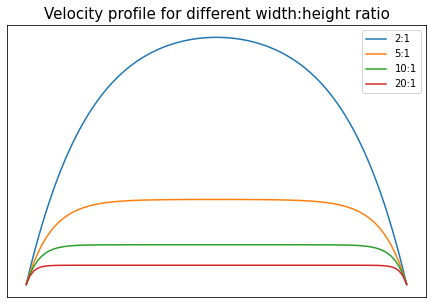

In [5]:
"""
  Compute the velocity profile in the y axis for change in width from -width/2 to width/2 
  with increments of x 
"""
fig, ax = plt.subplots(figsize=(7.5,5))

#Input
vis_fluid = 0.00105 #Unit (Pa.s)
frate_fluid = 100 * (1.67*10**(-11)) # Unit (m3/s), example flow rate considered in the calculations 
h_channel = 100 #Unit (um) 
width_y = [200, 500, 1000, 2000] #Unit (um)
label_y = ['2:1','5:1','10:1','20:1']

v_x_array_together = []

for value_width in width_y:
  #Create an empty array to store the the value of the velocity for individual width 
  v_x_array = []
  #Create an array from -width/2 to width/2 for width of the channel
  interval_width = np.linspace(-value_width/2, value_width/2, 100) #Unit (um)
  #Compute the instantaneous rate of change in pressure along the channel
  dp = pressure_drop(frate_fluid, h_channel, value_width) #Unit (Pa/m)
  #Compute the velocity profile 
  for num in interval_width:
    v_x = velocity_x(num, 0, h_channel, value_width, -dp, vis_fluid) 
    v_x_array.append(v_x)
  
  #Convert the velocity units to (mm/s)
  v_x_array[:] = map(lambda x: x*(10**(12)), v_x_array) 
  v_x_array_together.append(v_x_array)

#Plot data
for i, x in enumerate(v_x_array_together):
  ax.plot(x, label=f'{label_y[i]}')

#Label plot
ax.set_ylabel('Velocity (mm/s)', fontsize=15)
ax.set_xlabel('Width of the channel', fontsize=15 )
ax.tick_params(axis='y', which='major', labelsize=11 )
ax.xaxis.set_visible(False), ax.yaxis.set_visible(False)
ax.legend()
ax.set_title('Velocity profile for different width:height ratio', fontsize=15)


In [6]:
"""
  Compute the flow rate assuming:
    - Width for the maximum WSS (12 dyn/cm2) must be 2000 considering the width-to-height 
    ratio of 20
"""

#Interval considered to look for the flow rate
search_interval_frate = np.linspace(start=200, stop=300)
#Tolerance for WSS
i_wss, f_wss = 11.9, 12.1

for i in search_interval_frate:
  current_wss = wall_shear_stress(i, 100, 2000)

  if (current_wss > i_wss and current_wss < f_wss):
    break 

print(f'The flow rate: {i} corresponds to a WSS of {current_wss}')


The flow rate: 226.53061224489795 corresponds to a WSS of 11.916642857142854


In [10]:
print(reynolds_number(230, 100, 2000))

3.5640299319727893
